In [1]:
from LegoRL import *

In [2]:
import gym
def make_env():
    def _thunk():
        env = gym.make('CartPole-v0').unwrapped
        return env
    return _thunk

In [3]:
import torch
import torch.nn as nn

CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 20),
                nn.ReLU(),
                nn.Linear(20, output_size),
                nn.ReLU()
)

# Advantage Actor Critic

In [9]:
class A2C(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner            = Runner(self, threads=8)
        self.rollout_collector = RolloutCollector(self, rollout_length=5)
        
        self.backbone     = Model(self, CartpoleNN, output=Embedding(64))
        self.policy       = PolicyNetwork(self, input=Embedding(64))
        self.critic       = VNetwork(self, input=Embedding(64))
        
        self.maxtrace     = MaxTrace(self)
        
        self.actor_loss   = ActorLoss(self)
        self.critic_loss  = CriticLoss(self, weight=0.5)
        self.entropy_loss = EntropyLoss(self, weight=0.1)
        self.trainer      = Trainer(self, models=[self.backbone, self.policy, self.critic])
        
    def iteration(self):
        # forward pass through network
        embedding = self.backbone(self.runner.states)
        policy = self.policy(embedding)
        V = self.critic(embedding)
        
        # perform step in environment
        actions = policy.sample()    
        transition = self.runner.step(actions)
        transition.update(V = V, policy = policy)
        
        # collect rollouts
        rollout = self.rollout_collector.add(transition)
        if rollout:
            # compute targets
            with torch.no_grad():
                last_embedding = self.backbone(self.runner.states)
                last_V = self.critic(last_embedding)

                target_V = self.maxtrace(rollout.rewards, rollout.discounts, last_V)
                adv = target_V.subtract_v(rollout.V)
            
            # optimize networks
            loss1 = self.actor_loss(rollout.policy, rollout.actions, adv)
            loss2 = self.critic_loss(rollout.V, target_V)
            loss3 = self.entropy_loss(rollout.policy)
            
            self.trainer.optimize(loss1 + loss2 + loss3)

In [10]:
a2c = A2C(make_env=make_env)
visualizer = Visualizer(a2c)

Runner: environment initialization... Finished.
Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <PolicyNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


In [11]:
a2c

<Runner>: Makes steps in 8 parallel environments
<RolloutCollector>: Collects rollouts of length 5
<Model>: Models Embedding of size 64
<PolicyNetwork>: Models Discrete Policy
<VNetwork>: Models V-function
<MaxTrace>: Estimates maxtrace returns
<ActorLoss>: Calculates policy loss
<CriticLoss>: Calculates TD loss
<EntropyLoss>: Calculates entropy penalty
<Trainer>: Standard SGD loss optimization
<Visualizer>: Plots logs every 1000 iteration

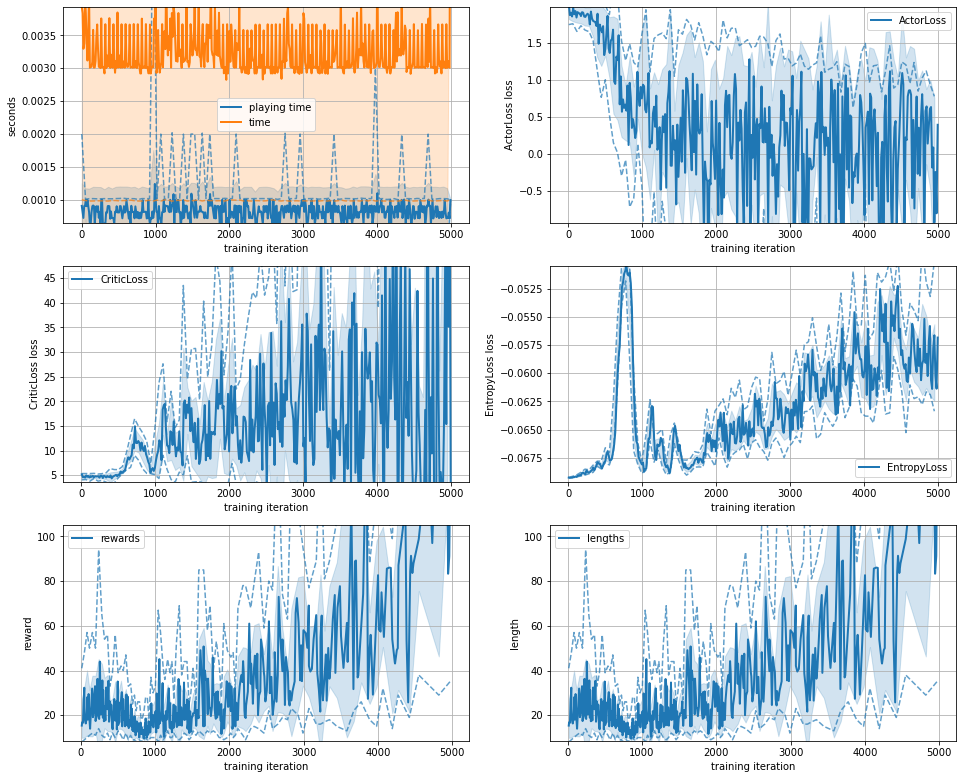

In [12]:
a2c.run(5000)

In [13]:
a2c.runner.fps

2473.2034866870263

# QAC

Actor-Critic where critic is trained via Q-learning. Yep.

In [4]:
class Critic(RLmodule):
    def __init__(self, parent):
        super().__init__(parent)
        
        self.q_network      = QNetwork(self, CartpoleNN)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.target         = OneStep(self)
        self.loss           = CriticLoss(self)
    
    def get_loss(self):        
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.target(self.target_network, **batch)
            loss = self.loss(prediction, target)
        else:
            loss = None
            
        self.target_network.update()
        return loss

In [5]:
class Actor(RLmodule):
    def __init__(self, parent):
        super().__init__(parent)
        
        self.policy     = PolicyNetwork(self, CartpoleNN)        
        self.maxtrace   = MaxTrace(self)        
        self.actor_loss = ActorLoss(self)
        
    def get_loss(self, rollout, critic, last_state):
        with torch.no_grad():
            last_V = critic.q_network.V(last_state)      
            target_V = self.maxtrace(rollout.rewards, rollout.discounts, last_V)

            V = critic.q_network.V(rollout.states, rollout.policy)
            adv = target_V.subtract_v(V)

        return self.actor_loss(rollout.policy, rollout.actions, adv)

In [6]:
class QAC(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner            = Runner(self, threads=8)
        self.rollout_collector = RolloutCollector(self, rollout_length=5)
        
        self.actor  = Actor(self)
        self.critic = Critic(self)
        
        self.trainer = Trainer(self, models=[self.critic.q_network, self.actor.policy])
        
    def iteration(self):
        states = self.runner.states
        policy = self.actor.policy(states)
        actions = policy.sample()
            
        transition = self.runner.step(actions)
        self.critic.replay.store(transition)
        
        transition.update(policy = policy)            
        rollout = self.rollout_collector.add(transition)
        
        if rollout:
            loss1 = self.critic.get_loss()
            if loss1:
                loss2 = self.actor.get_loss(rollout, self.critic, self.runner.states)

                self.trainer.optimize(loss1 + loss2)

In [7]:
qac = QAC(make_env=make_env)

Runner: environment initialization... Finished.
Initializing <PolicyNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])
Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


In [8]:
qac

<Runner>: Makes steps in 8 parallel environments
<RolloutCollector>: Collects rollouts of length 5
<Actor>:
    <Actor.PolicyNetwork>: Models Discrete Policy
    <Actor.MaxTrace>: Estimates maxtrace returns
    <Actor.ActorLoss>: Calculates policy loss
    
<Critic>:
    <Critic.QNetwork>: Models Q-function
    <Critic.FrozenModule>: Frozen copy of <Critic.QNetwork>
    <Critic.ReplayBuffer>: Stores data in raw numpy format
    <Critic.Sampler>: Samples mini-batches uniformly
    <Critic.OneStep>: Returns one-step approximation
    <Critic.CriticLoss>: Calculates TD loss
    
<Trainer>: Standard SGD loss optimization

In [9]:
visualizer = Visualizer(qac)
a2c_player = Player(qac, policy=qac.actor.policy.act, timer=250)
dqn_player = Player(qac, policy=qac.critic.q_network.act, timer=250)

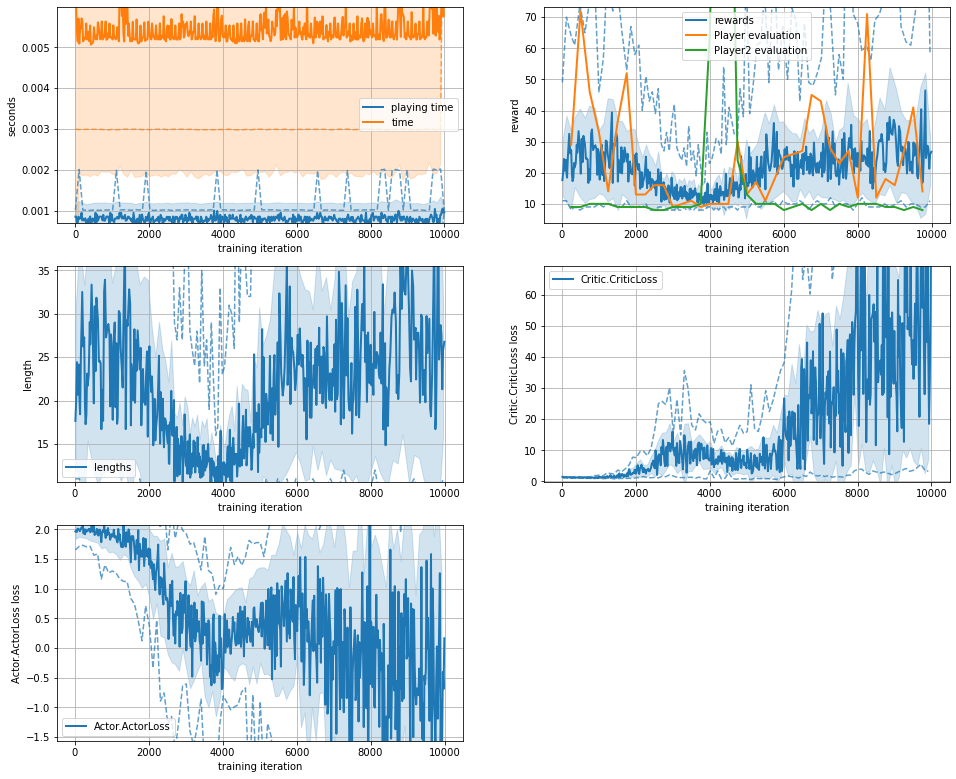

In [11]:
qac.run(10000)

# Proximal Policy Optimization

In [4]:
class PPO(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner            = Runner(self, threads=8)
        self.rollout_collector = RolloutCollector(self, rollout_length=32)
        self.epoched_sampler   = EpochedRollout(self, epochs=3)
        
        self.backbone     = Model(self, CartpoleNN, output=Embedding(64))
        self.policy       = PolicyNetwork(self, input=Embedding(64))
        self.critic       = VNetwork(self, input=Embedding(64))
        
        self.gae          = GAE(self, tau=1)
        
        self.actor_loss   = ProximalLoss(self)
        self.critic_loss  = CriticLoss(self, weight=0.5)
        self.entropy_loss = EntropyLoss(self, weight=0.01)
        self.trainer      = Trainer(self, models=[self.backbone, self.policy, self.critic])        
        
    def iteration(self):
        batch = self.epoched_sampler.sample_next()
        
        if batch is None:
            # collecting data stage
            with torch.no_grad():
                # forward pass through network
                embedding = self.backbone(self.runner.states)
                policy = self.policy(embedding)
                V = self.critic(embedding)
                actions = policy.sample()
                
                # collect rollout of transitions
                transition = self.runner.step(actions)        
                transition.update(V=V, policy=policy)            
                rollout = self.rollout_collector.add(transition)
                
                # if got enough transitions
                if rollout:
                    # compute GAE advantages
                    last_embedding = self.backbone(self.runner.states)
                    last_V = self.critic(last_embedding)
                    adv = self.gae(rollout.rewards, rollout.V, rollout.discounts, last_V)
                    
                    # store collected dataset
                    self.epoched_sampler.new_dataset(Storage(states=rollout.states, 
                                                             actions=rollout.actions, 
                                                             old_policy=rollout.policy, 
                                                             old_V = rollout.V, 
                                                             adv = adv))
        else:
            # training stage            
            embedding = self.backbone(batch.states)
            policy = self.policy(embedding)
            V = self.critic(embedding)
            
            # target for critic is GAE advantage + old V(s)
            target_V = batch.adv.add_v(batch.old_V)
            
            # optimize
            loss1 = self.actor_loss(policy, batch.old_policy, batch.actions, batch.adv)
            loss2 = self.critic_loss(V, target_V)
            loss3 = self.entropy_loss(policy)
            
            self.trainer.optimize(loss1 + loss2 + loss3)

In [5]:
ppo = PPO(make_env=make_env)
visualizer = Visualizer(ppo)

Runner: environment initialization... Finished.
Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <PolicyNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


In [6]:
ppo

<Runner>: Makes steps in 8 parallel environments
<RolloutCollector>: Collects rollouts of length 32
<EpochedRollout>: Performs 3 epoches with batches of size 32 on provided dataset
<Model>: Models Embedding of size 64
<PolicyNetwork>: Models Discrete Policy
<VNetwork>: Models V-function
<GAE>: Estimates GAE advantages
<ProximalLoss>: Calculates PPO gradient estimation
<CriticLoss>: Calculates TD loss
<EntropyLoss>: Calculates entropy penalty
<Trainer>: Standard SGD loss optimization
<Visualizer>: Plots logs every 1000 iteration

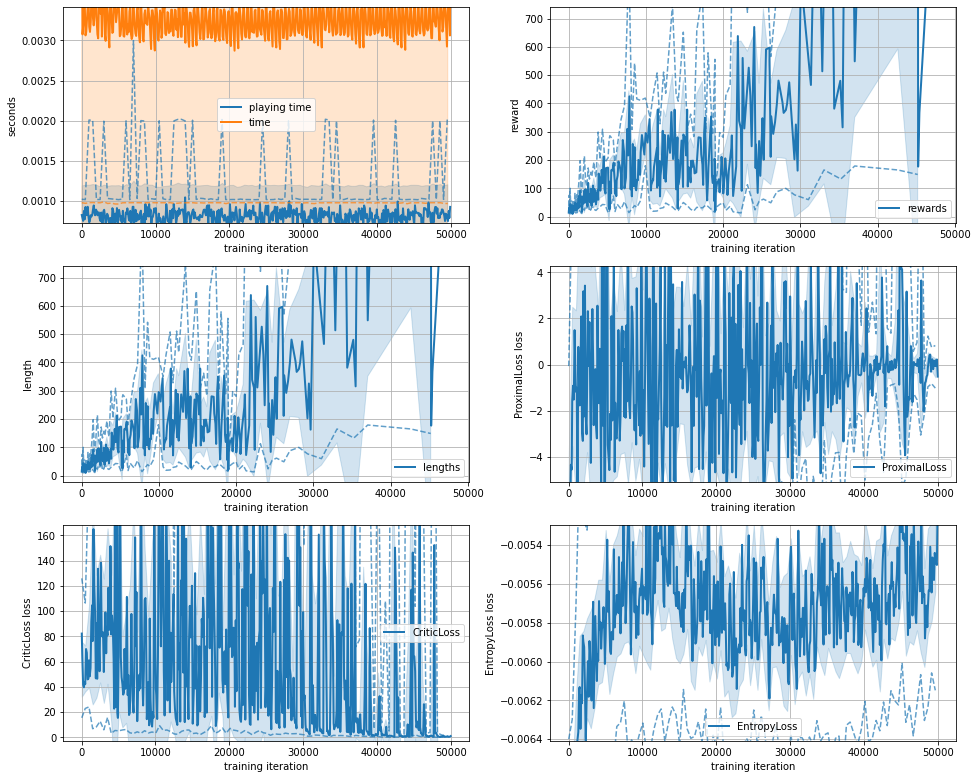

In [7]:
ppo.run(50000)

In [8]:
ppo.runner.fps

1407.5850542123992